# Testing things in the notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import sys
%matplotlib inline
sys.version

'3.6.3 |Intel Corporation| (default, Feb 12 2018, 00:33:07) \n[GCC 4.2.1 Compatible Apple LLVM 7.3.0 (clang-703.0.31)]'

Import the necessary Libraries 

In [2]:
from pyworkout.parsers import tcxtools

How bad does one of the TCX files look? The data cleaning will be done by the framework, but look how bad it is in raw form

In [3]:
workout_data = tcxtools.TCXPandas('raw_data/activity_248017020.tcx') # Create the Class Object
workout_data_dd = workout_data.parse()

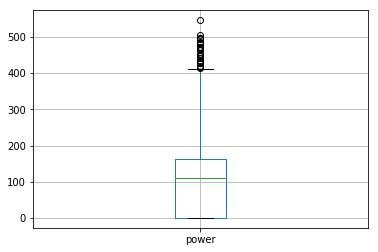

In [7]:
workout_data_dd.boxplot('power')

## Explore and visualize some of the data

Free form here: play with pandas a bit to see what is possible.  Note that you can actually instantiate pandas graphing using matplotlib here

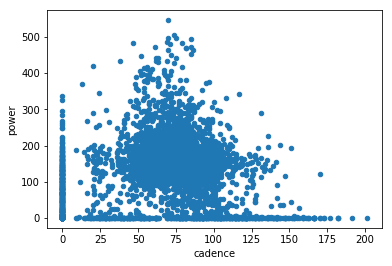

In [8]:
workout_data_dd.plot.scatter('cadence','power')

## Playing with Bokeh

In [9]:
import bokeh

In [10]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
output_notebook()

p = figure(title="Exploring power vs distance", x_axis_label='x', y_axis_label='y')
p.line(workout_data_dd.distance, workout_data_dd.power, legend="Power (Watts)", line_width=2)

# show the results
show(p)

Loading BokehJS ...

In [11]:
output_notebook()
p = figure(title="Exploring power vs cadence", x_axis_label='x', y_axis_label='y')
p.scatter(workout_data_dd.power, workout_data_dd.cadence)

# show the results
show(p)

Loading BokehJS ...

## Scikit-learn: some quick fun testing

Import the basic model necessities

In [8]:
from sklearn import model_selection
from sklearn import linear_model

Parse the dataset, then add in model_selection's train/test split
before training the model, drop the following features: time, power, latitude, longitude

We are trying to calculate the power (target) based on the other features

In [12]:
dataset = workout_data.parse()
# Reduce the dataset
red_dataset = dataset.drop(['time','power','latitude','longitude'], axis=1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(red_dataset, dataset.power, test_size=0.33, random_state=42)

In [13]:
regression_model = linear_model.LinearRegression()
regression_model.fit(X_train, y_train)
mse = np.mean((regression_model.predict(X_test) - y_test) ** 2)
score = regression_model.score(X_test, y_test)
print(regression_model.coef_, mse, score, regression_model)

[-2.24028439e-01  1.06279541e+00 -4.51519249e-05  1.48845670e+00
 -3.89340780e+00] 5094.811791189181 0.4334123966981575 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


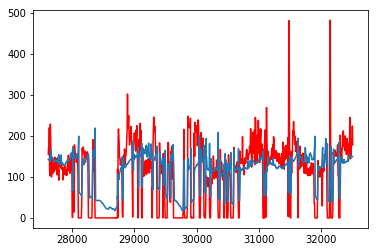

In [14]:
pred_values = regression_model.predict(dataset.drop(['time','power','latitude','longitude'], axis=1))
plt.plot(dataset.distance[5000:6000], dataset.power[5000:6000], c='red')
plt.plot(dataset.distance[5000:6000], pred_values[5000:6000])
plt.show()

In [15]:
red_dataset.columns

Index(['altitude', 'cadence', 'distance', 'hr', 'speed'], dtype='object')

# Scaling out via Dask

One of the neat things of dask is when you need general analysis in concurrent flows to be accomplished
What is the code doing below?

In [16]:
import dask.dataframe as dd
from distributed import client
from dask import delayed
tcx_list = glob.glob("raw_data/*.tcx")
list_of_delayed = []
for files in tcx_list:
    list_of_delayed.append(delayed(tcxtools.TCXPandas(files).parse()))

In [17]:
list_of_delayed

[Delayed('DataFrame-6e884ad1-582a-4db8-9524-06540c9d62cd'),
 Delayed('DataFrame-5f727638-c3de-482a-ab1e-3807920685eb'),
 Delayed('DataFrame-64c05c06-aa97-456f-a29f-a3aac5e3503e'),
 Delayed('DataFrame-b91e58b3-1692-494c-bef1-13d5a5def55c'),
 Delayed('DataFrame-563e015a-cd63-4e93-a85d-7bad0758eabc'),
 Delayed('DataFrame-797654bc-88c8-41e2-9531-ba411af11977'),
 Delayed('DataFrame-1ac85d4e-6dcf-4051-8fb1-f9feae11924e'),
 Delayed('DataFrame-bcd81871-af9c-4421-b7b4-0ea26191e101')]

In [18]:
total = dd.from_delayed(list_of_delayed)

In [19]:
print(type(total))
total

<class 'dask.dataframe.core.DataFrame'>


,altitude,cadence,distance,hr,latitude,longitude,power,speed,time
npartitions=8,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,object
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


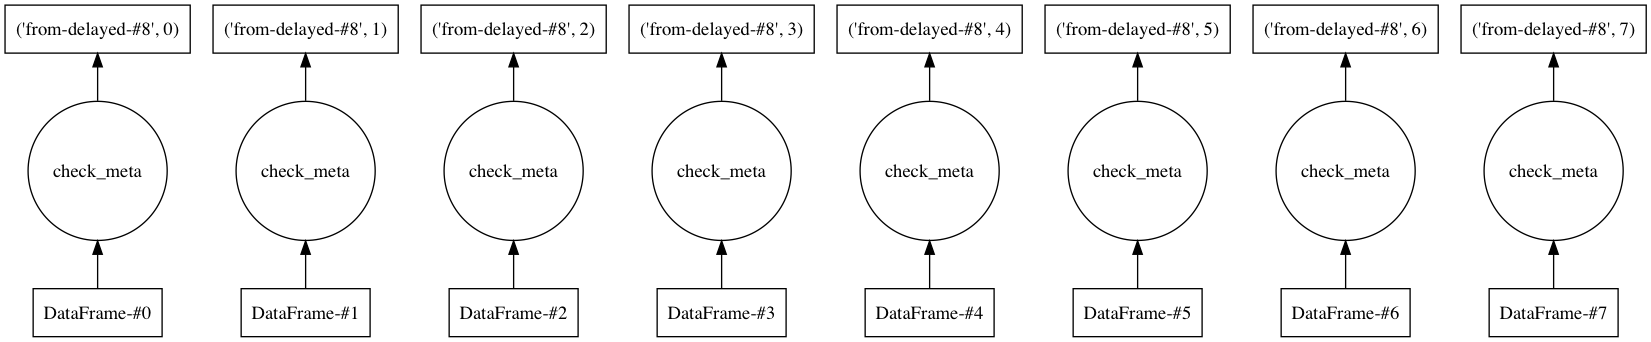

In [20]:
total.visualize()

In [21]:
full=total.compute()

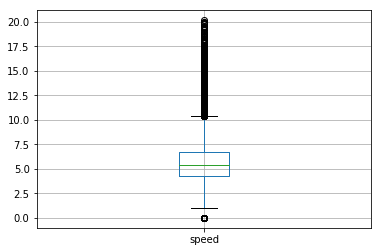

In [22]:
full.boxplot('speed')

In [23]:
munged_df = delayed(total.drop(['latitude','longitude'],axis=1))

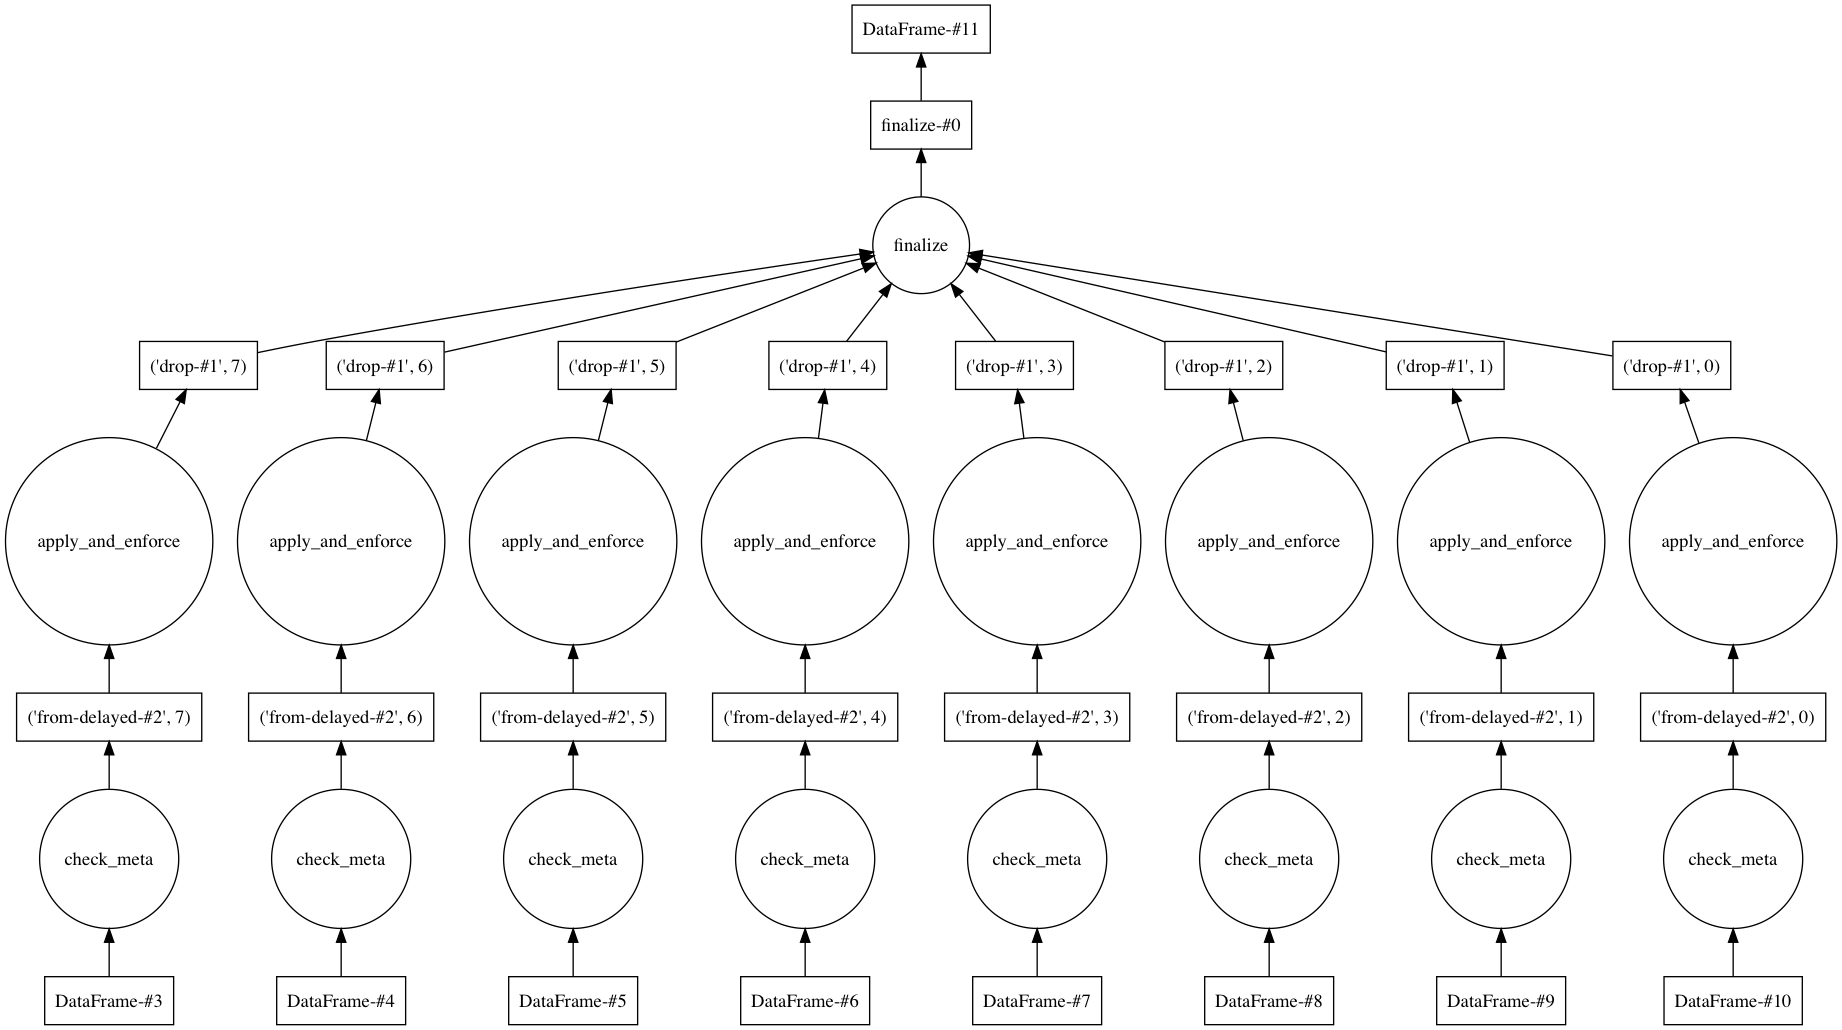

In [24]:
munged_df.visualize()

In [25]:
munged_df.compute().head()

,altitude,cadence,distance,hr,power,speed,time
0,220.600006,63.0,4.150000,75.0,51.0,4.152,2013-10-20T15:58:20.000Z
1,220.399994,114.0,8.620000,75.0,1.0,4.466,2013-10-20T15:58:21.000Z
2,220.399994,32.0,13.120000,77.0,34.0,4.374,2013-10-20T15:58:22.000Z
3,218.800003,69.0,17.350000,78.0,117.0,4.356,2013-10-20T15:58:23.000Z
4,218.800003,83.0,21.700001,80.0,106.0,4.356,2013-10-20T15:58:24.000Z


In [26]:
dd_dataset=munged_df.compute()

In [27]:
red_dataset = dd_dataset.drop(['time','power'], axis=1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(red_dataset, dd_dataset.power, test_size=0.33, random_state=42)
regression_model = linear_model.LinearRegression()
regression_model.fit(X_train, y_train)
mse = np.mean((regression_model.predict(X_test) - y_test) ** 2)
score = regression_model.score(X_test, y_test)
print(regression_model.coef_, mse, score, regression_model)

[-1.63564366e-01  1.11796931e+00 -6.09698846e-04  1.04422064e+00
 -5.34837688e+00] 5176.5317198892735 0.40804768411414055 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


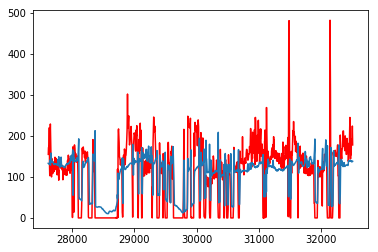

In [28]:
pred_values = regression_model.predict(dataset.drop(['time','power','latitude','longitude'], axis=1))
plt.plot(dataset.distance[5000:6000], dataset.power[5000:6000], c='red')
plt.plot(dataset.distance[5000:6000], pred_values[5000:6000])
plt.show()